In [ ]:
"""
File for converting raw ground truth data (multiple classes) to binary ground truth data 
(0 for background, 1 for gap junctions) 
"""

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img_dir = "/Users/huayinluo/Downloads/gap_junction_seg/image_export"
mask_dir = "/Users/huayinluo/Downloads/gap_junction_seg/segmentation_export"
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)

In [4]:
import re
# img file pattern: Dataset8_export_s{z value}_Y{y value}_X{x value}.png
# mask file pattern: SEM_adult_gj_segmentation_WL.vsseg_export_s{z value}_Y{y value}_X{x value}.png
mask_pattern = r"SEM_adult_gj_segmentation_WL.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png"
img_pattern = r"Dataset8_export_s(\d+)_Y(\d+)_X(\d+).png"

def get_z_y_x(file_name, pattern):
    match = re.match(pattern, file_name)
    if match:
        if len(match.groups()) != 3:
            return None
        z, y, x = match.groups()
        return int(z), int(y), int(x)
    else:
        return None
    
# sort the files by z, y, x (ensure that img and mask files are in the same order)
mask_files.sort(key=lambda x: get_z_y_x(x, mask_pattern))
img_files.sort(key=lambda x: get_z_y_x(x, img_pattern))
print(mask_files[:10])
print(img_files[:10])
print(len(mask_files), len(img_files))

['SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X0.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X1.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X2.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X3.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X4.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X5.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X6.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X7.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X8.png', 'SEM_adult_gj_segmentation_WL.vsseg_export_s200_Y0_X9.png']
['Dataset8_export_s200_Y0_X0.png', 'Dataset8_export_s200_Y0_X1.png', 'Dataset8_export_s200_Y0_X2.png', 'Dataset8_export_s200_Y0_X3.png', 'Dataset8_export_s200_Y0_X4.png', 'Dataset8_export_s200_Y0_X5.png', 'Dataset8_export_s200_Y0_X6.png', 'Dataset8_export_s200_Y0_X7.png', 'Dataset8_export_s200_Y0_X8.png', 'Dataset8_export_s200_Y0_X9.png']
18018 18018


In [6]:
# create directories
if not os.path.exists("small_data"):
    os.makedirs("small_data")
if not os.path.exists("small_data/original"):
    os.makedirs("small_data/original")
if not os.path.exists("small_data/ground_truth"):
    os.makedirs("small_data/ground_truth")
if not os.path.exists("small_data/original/train"):
    os.makedirs("small_data/original/train")
if not os.path.exists("small_data/original/valid"):
    os.makedirs("small_data/original/valid")
if not os.path.exists("small_data/original/test"):
    os.makedirs("small_data/original/test")
if not os.path.exists("small_data/ground_truth/train"):
    os.makedirs("small_data/ground_truth/train")
if not os.path.exists("small_data/ground_truth/valid"):
    os.makedirs("small_data/ground_truth/valid")
if not os.path.exists("small_data/ground_truth/test"):
    os.makedirs("small_data/ground_truth/test")
 

In [7]:
mask_pattern_const = r"SEM_adult_gj_segmentation_WL.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png"
img_pattern_const = r"Dataset8_export_s(\d+)_Y(\d+)_X(\d+).png"
def get_z_y_x(file_name, pattern):
    match = re.match(pattern, file_name)
    if match:
        if len(match.groups()) != 3:
            return None
        z, y, x = match.groups()
        return int(z), int(y), int(x)
    else:
        return None
    
def get_img_by_coords(z, y, x, img_pattern=img_pattern_const):
    """ get path of image by z, y, x """
    for img_file in img_files:
        z_, y_, x_ = get_z_y_x(img_file, img_pattern)
        if z == z_ and y == y_ and x == x_:
            return cv2.imread(os.path.join(img_dir, img_file), cv2.IMREAD_GRAYSCALE)
    return None

def get_mask_by_coords(z, y, x, mask_pattern=mask_pattern_const):
    """ get path of mask by z, y, x """
    for mask_file in mask_files:
        z_, y_, x_ = get_z_y_x(mask_file, mask_pattern)
        if z == z_ and y == y_ and x == x_:
            return cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
    return None

def get_3d_slice(z,y,x, depth=1, width=512, height=512):
    """ get 3d slice by z, y, x 
    
    -think of the original image as 3d volume, and each slice is a pixel
    -so we want a column of pixels, with the center pixel being the pixel at z, y, x, and sliding up and down along the z axis
    
    """
    img_3d = np.zeros((2*depth+1, width, height))
    mask_3d = np.zeros((2*depth+1, width, height))
    for i in range(-depth, depth+1):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x)
        mask = get_mask_by_coords(z_coord, y, x)
        if img is not None and mask is not None:
            img_3d[i+depth] = img
            mask_3d[i+depth] = mask
    return img_3d, mask_3d

In [12]:
# choose images with gap junctions
# 0, 2: background
# 1, 3: gap junction
imgs = []
masks = []
unique_values = []
background_values = [0, 2]
gap_junction_values = [1, 3]
for i in range(len(img_files)):
    img_f = img_files[i]
    mask_f = mask_files[i]
    mask = cv2.imread(os.path.join(mask_dir, mask_f))
    img = cv2.imread(os.path.join(img_dir, img_f))
    processed_mask = mask.copy()
    processed_mask[np.isin(processed_mask, background_values)] = 0
    processed_mask[np.isin(processed_mask, gap_junction_values)] = 1
    
    # save imgs where gap junctions are present
    if (len(np.unique(processed_mask))>1):
        labels = np.unique(processed_mask)
        for label in labels:
            if label not in unique_values:
                unique_values.append(label)
                print(f"Unique value {label} found in mask {mask_f}")
        mask[mask == 3] = 1
        mask[mask == 2] = 0
        mask_visual = mask.copy()
        mask_visual[mask_visual == 1] = 255
        print(f"Unique values in mask {mask_f}: {np.unique(mask)}")
        img_z, img_y, img_x = get_z_y_x(img_f, img_pattern)
        mask_z, mask_y, mask_x = get_z_y_x(mask_f, mask_pattern)
        if (img_z != mask_z) or (img_y != mask_y) or (img_x != mask_x):
            print(f"Image and mask coordinates do not match: {img_f}, {mask_f}")
            print(f"Image: {img_z}, {img_y}, {img_x}")
            print(f"Mask: {mask_z}, {mask_y}, {mask_x}")
            continue
        plt.imsave(f"small_data/ground_truth_visual/z{mask_z}_y{mask_y}_x{mask_x}.png", mask_visual)
        # plt.imsave(f"small_data/original/z{img_z}_y{img_y}_x{img_x}.png", img)
        # plt.imsave(f"small_data/ground_truth/z{mask_z}_y{mask_y}_x{mask_x}.png", mask)
                
    print(f"Checked {i} out of {len(img_files)} | progress: {i/len(img_files)*100:.2f}%")

Checked 0 out of 18018 | progress: 0.00%
Checked 1 out of 18018 | progress: 0.01%
Checked 2 out of 18018 | progress: 0.01%
Checked 3 out of 18018 | progress: 0.02%
Checked 4 out of 18018 | progress: 0.02%
Checked 5 out of 18018 | progress: 0.03%
Checked 6 out of 18018 | progress: 0.03%
Checked 7 out of 18018 | progress: 0.04%
Checked 8 out of 18018 | progress: 0.04%
Checked 9 out of 18018 | progress: 0.05%
Checked 10 out of 18018 | progress: 0.06%
Checked 11 out of 18018 | progress: 0.06%
Checked 12 out of 18018 | progress: 0.07%
Checked 13 out of 18018 | progress: 0.07%
Checked 14 out of 18018 | progress: 0.08%
Checked 15 out of 18018 | progress: 0.08%
Checked 16 out of 18018 | progress: 0.09%
Checked 17 out of 18018 | progress: 0.09%
Checked 18 out of 18018 | progress: 0.10%
Checked 19 out of 18018 | progress: 0.11%
Checked 20 out of 18018 | progress: 0.11%
Checked 21 out of 18018 | progress: 0.12%
Checked 22 out of 18018 | progress: 0.12%
Checked 23 out of 18018 | progress: 0.13%
Ch

In [68]:
print(f"Unique values: {unique_values}")

Unique values: [0, 1]


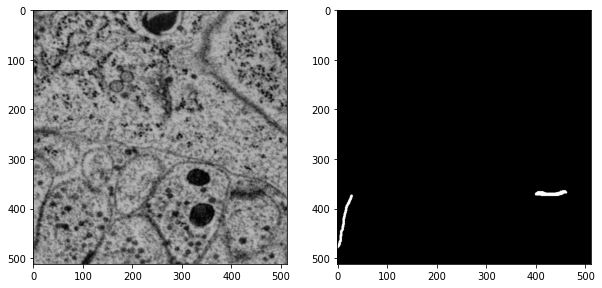

In [70]:
# sanity check: do images and masks match?
i=1
tmp_img = imgs[i]
tmp_mask = masks[i]
tmp_mask[tmp_mask > 0] = 255
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(tmp_img)
ax[1].imshow(tmp_mask)

In [71]:
# split data into train, valid, test
num_imgs = len(imgs)
indices = np.arange(num_imgs)
np.random.shuffle(indices)
train_indices = indices[:int(0.6*num_imgs)]
valid_indices = indices[int(0.6*num_imgs):int(0.8*num_imgs)]
test_indices = indices[int(0.8*num_imgs):]
imgs = np.array(imgs)
masks = np.array(masks)

In [74]:
train_imgs = imgs[train_indices]
valid_imgs = imgs[valid_indices]
test_imgs = imgs[test_indices]

train_masks = masks[train_indices]
valid_masks = masks[valid_indices]
test_masks = masks[test_indices]
print(f"Train: {train_masks.shape}, {train_imgs.shape}") # (num_imgs, 512, 512, 3)

Train: (213, 512, 512, 3), (213, 512, 512, 3)


[0 1]


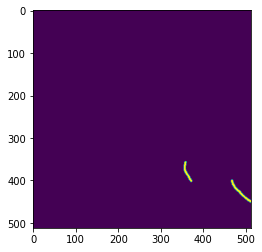

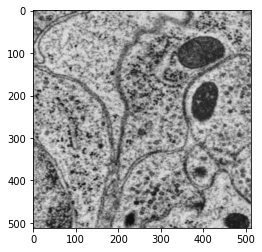

In [77]:
k = 200
tmp = train_masks[k][:, :, 0]
img = train_imgs[k]
print(np.unique(tmp))
plt.imshow(tmp)
plt.show()
plt.imshow(img)

In [80]:

# save imgs
for i,img in enumerate(train_imgs):
    cv2.imwrite(f"small_data/original/train/{i}.png", train_imgs[i])
    print(f"Saved train {i}")

for i,img in enumerate(valid_imgs):
    cv2.imwrite(f"small_data/original/valid/{i}.png", valid_imgs[i])
    print(f"Saved valid {i}")

for i,img in enumerate(test_imgs):
    cv2.imwrite(f"small_data/original/test/{i}.png", test_imgs[i])
    print(f"Saved test {i}")

# save masks
for i,img in enumerate(train_masks):
    plt.imsave(f"small_data/ground_truth/train/{i}.png", train_masks[i][:, :, 1])
    print(f"Saved train mask {i}")

for i,img in enumerate(valid_masks):
    plt.imsave(f"small_data/ground_truth/valid/{i}.png", valid_masks[i][:, :, 1])
    print(f"Saved valid mask {i}")

for i,img in enumerate(test_masks):
    plt.imsave(f"small_data/ground_truth/test/{i}.png", test_masks[i][:, :, 1])
    print(f"Saved test mask {i}")

Saved train 0
Saved train 1
Saved train 2
Saved train 3
Saved train 4
Saved train 5
Saved train 6
Saved train 7
Saved train 8
Saved train 9
Saved train 10
Saved train 11
Saved train 12
Saved train 13
Saved train 14
Saved train 15
Saved train 16
Saved train 17
Saved train 18
Saved train 19
Saved train 20
Saved train 21
Saved train 22
Saved train 23
Saved train 24
Saved train 25
Saved train 26
Saved train 27
Saved train 28
Saved train 29
Saved train 30
Saved train 31
Saved train 32
Saved train 33
Saved train 34
Saved train 35
Saved train 36
Saved train 37
Saved train 38
Saved train 39
Saved train 40
Saved train 41
Saved train 42
Saved train 43
Saved train 44
Saved train 45
Saved train 46
Saved train 47
Saved train 48
Saved train 49
Saved train 50
Saved train 51
Saved train 52
Saved train 53
Saved train 54
Saved train 55
Saved train 56
Saved train 57
Saved train 58
Saved train 59
Saved train 60
Saved train 61
Saved train 62
Saved train 63
Saved train 64
Saved train 65
Saved train 66
Saved